In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
from IPython.display import display, clear_output

In [3]:
import sys
sys.path.append('../../..')

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from magrec.prop.Fourier import FourierTransform2d
from magrec.prop.Kernel import HarmonicFunctionComponentsKernel, MagneticFieldToCurrentInversion2d
from magrec.prop.Propagator import CurrentPropagator2d, AxisProjectionPropagator
from magrec.misc.plot import plot_n_components
from magrec.nn.arch import GeneratorCNN
from magrec import __datapath__

In [17]:
from magrec.misc.load import load_matlab_data

In [18]:
mat = load_matlab_data(__datapath__ / "ExperimentalData" / "Harvard" / "XY_Bnv_Bxyz_Jxy_SChenJJ.mat")
B_NV = torch.tensor(mat['Bnv_map'].T)
B_NV.shape  # (39, 141) — notice that it is probably bad to have an odd number of pixels

torch.Size([141, 39])

## 1. Reconstruction of B fields

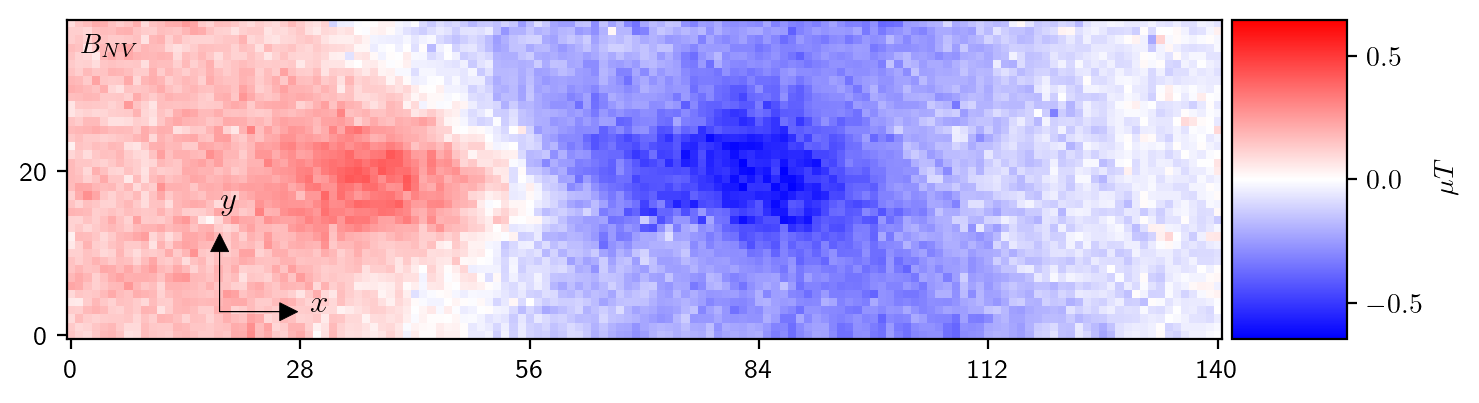

In [19]:
plot_n_components(B_NV * 1e6, labels=[r'$B_{NV}$'], cmap="bwr", units=r"$\mu T$")

In [20]:
# inspect the coordinate vectors to check for spacing
x_vector = mat["rx_inv"]
y_vector = mat["ry_inv"]

print(np.unique(np.diff(x_vector)))
print(np.unique(np.diff(y_vector)))

[0.01692525 0.01692525 0.01692525 0.01692525 0.01692525 0.01692525
 0.01692525 0.01692525 0.01692525]
[0.02916667 0.02916667 0.02916667 0.02916667 0.02916667 0.02916667
 0.02916667]


In [21]:
# data from inspecting the matlab file  
dx=0.0169  # in μm
dy=0.0292

# data from the .pptx shared by the authors
theta = 54.7  # degrees
phi = 30.0 +90 # degrees

ft = FourierTransform2d(B_NV.shape, dx=dx, dy=dy)
kernel = HarmonicFunctionComponentsKernel.define_kernel_matrix(ft.kx_vector, ft.ky_vector, theta=theta, phi=phi)
b_NV = ft.forward(B_NV, dim=(-2, -1))

kernel.shape


torch.Size([3, 141, 20])

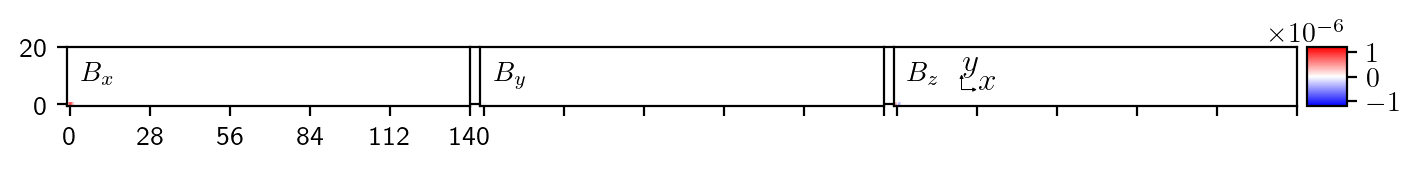

In [22]:

b = torch.einsum("jkl,kl->jkl", kernel, b_NV)
B = ft.backward(b, dim=(-2, -1))
B[0,::] = B[0,::] + 5e-7 

plot_n_components(B, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic", "extent": [x_vector.min(), x_vector.max(), y_vector.min(), y_vector.max()]})

# plot_n_components(B[:,:,40:80], symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
# imshow_kwargs={"interpolation": "bicubic", "extent": [x_vector.min(), x_vector.max(), y_vector.min(), y_vector.max()]})


In [14]:
# padded_B_NV = FourierPadder.pad_2d(B_NV)
# padded_B_NV = FourierPadder.pad_2d(B_NV, (10,10), 'linear_ramp', plot=True)

ft = FourierTransform2d(padded_B_NV.shape, dx=dx, dy=dy)
b_NV = ft.forward(padded_B_NV, dim=(-2, -1))
kernel = HarmonicFunctionComponentsKernel.define_kernel_matrix(ft.kx_vector, ft.ky_vector, theta=theta, phi=phi)
b = torch.einsum("cjk,jk->cjk", kernel, b_NV)
B = ft.backward(b, dim=(-2, -1))
B.shape # (3, n_x, n_y) <- this should give real vector field map

torch.Size([3, 282, 78])

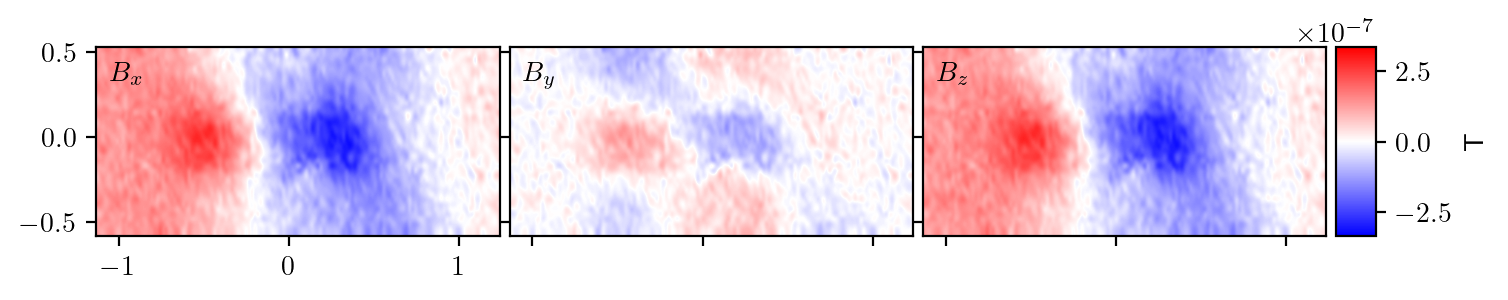

In [15]:
plot_n_components(B[:, :141, :39], symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", units="T",
imshow_kwargs={
    "extent": [x_vector.min(), x_vector.max(), y_vector.min(), y_vector.max()],
    "interpolation": "bicubic",
    })

In [132]:
height = 0.015 # in μm
layer_thickness = 0 # put 1 for now to get result per μm
inversion_kernel = MagneticFieldToCurrentInversion2d.define_kernel_matrix(ft.kx_vector, ft.ky_vector, height=height, layer_thickness=layer_thickness)

Applied a high frequency filter, removing all components smaller than 0.015 um
Applied a high frequency filter, removing all components smaller than 0.015 um


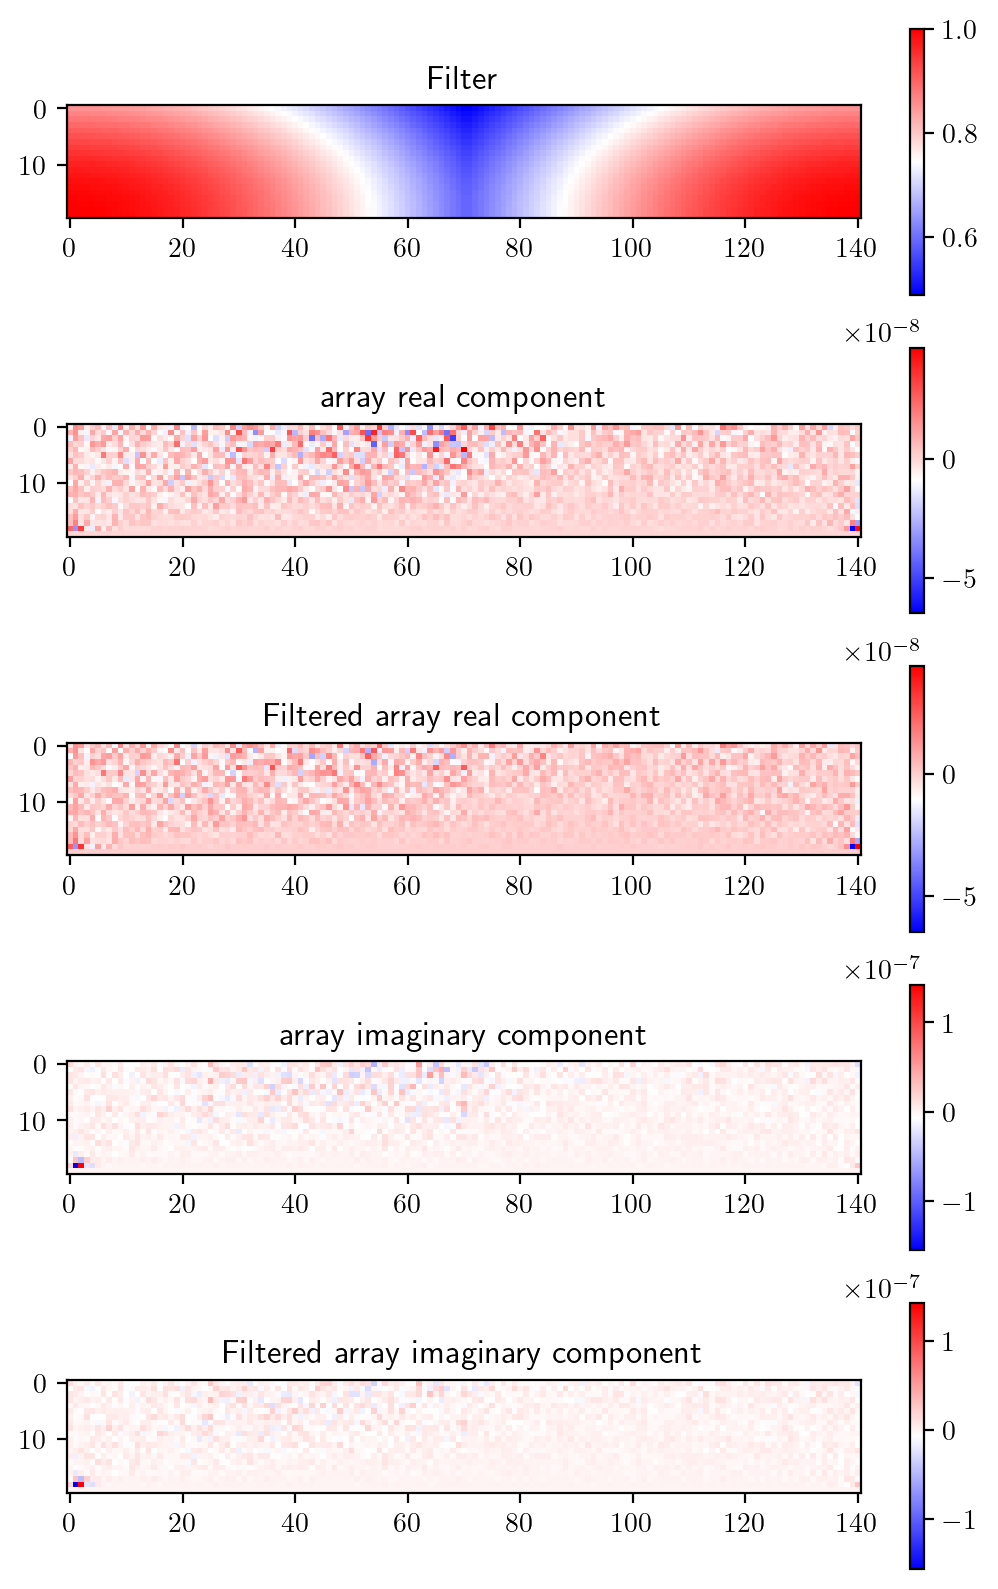

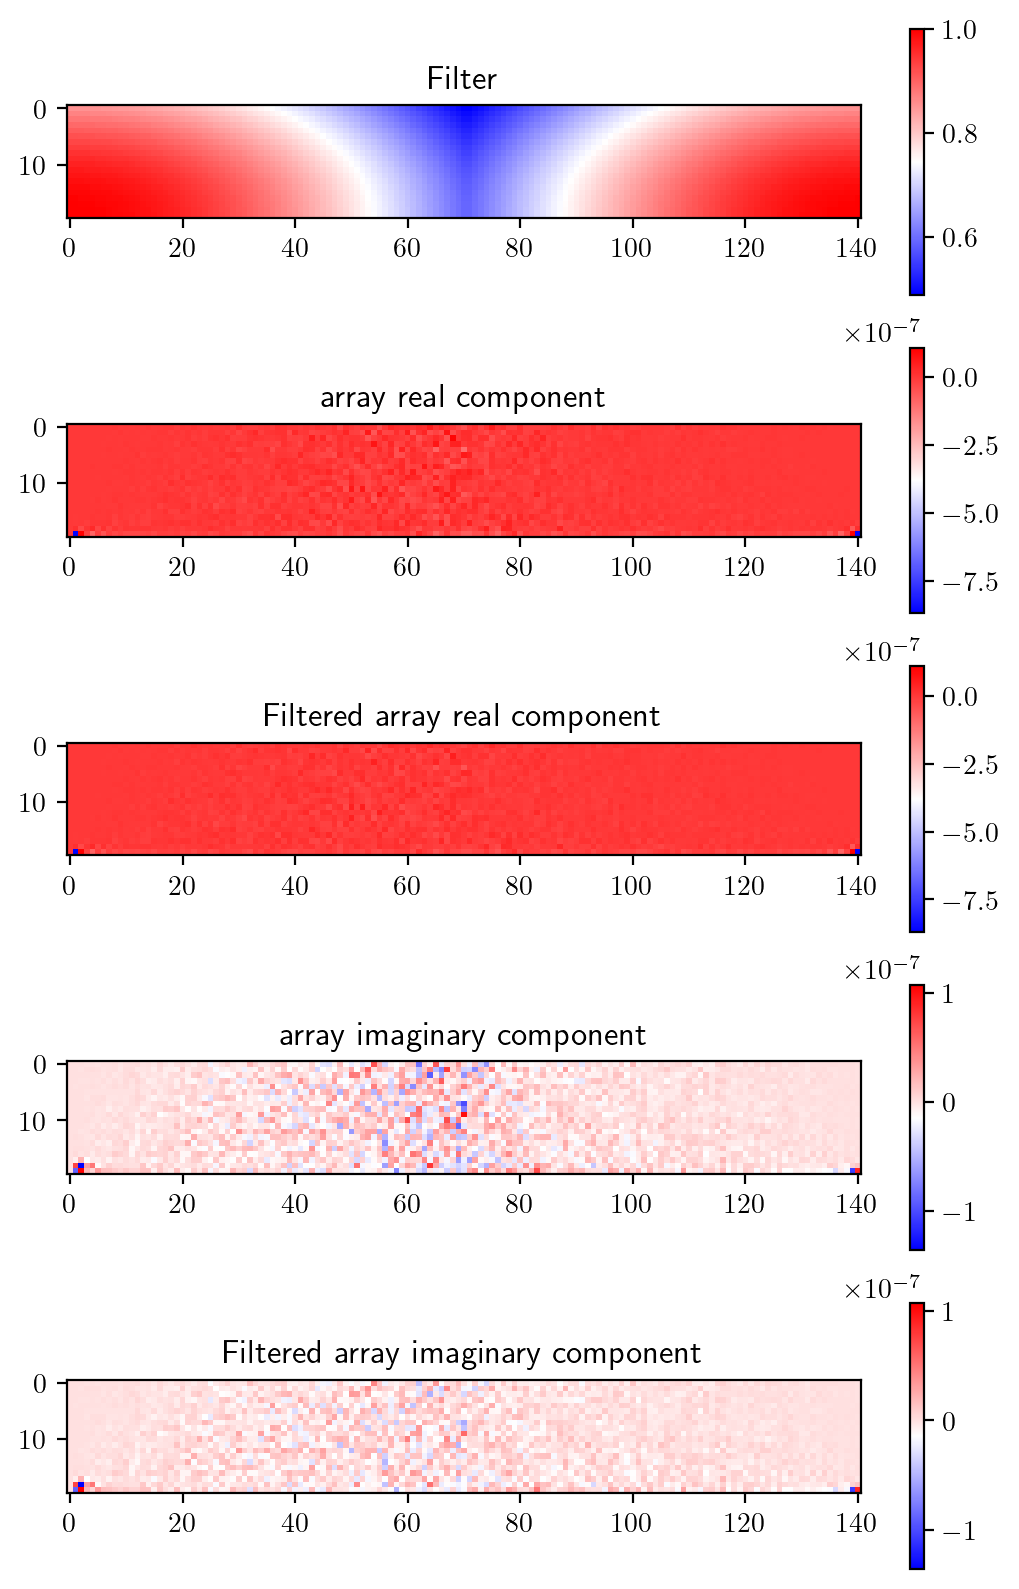

In [135]:
bxby = b[:2, :, :].type(dtype=torch.complex64)
jxjy = torch.einsum('vcjk,cjk->vjk', inversion_kernel, bxby)
jxjy[0,::] = FourierPadder.apply_hanning(jxjy[0,::], ft.k_matrix, height, high_freq_cutoff = height, low_freq_cutoff = None, plot = True)
jxjy[1,::] = FourierPadder.apply_hanning(jxjy[1,::], ft.k_matrix, height, high_freq_cutoff = height, low_freq_cutoff = None, plot = True)
JxJy = ft.backward(jxjy, dim=(-2, -1))

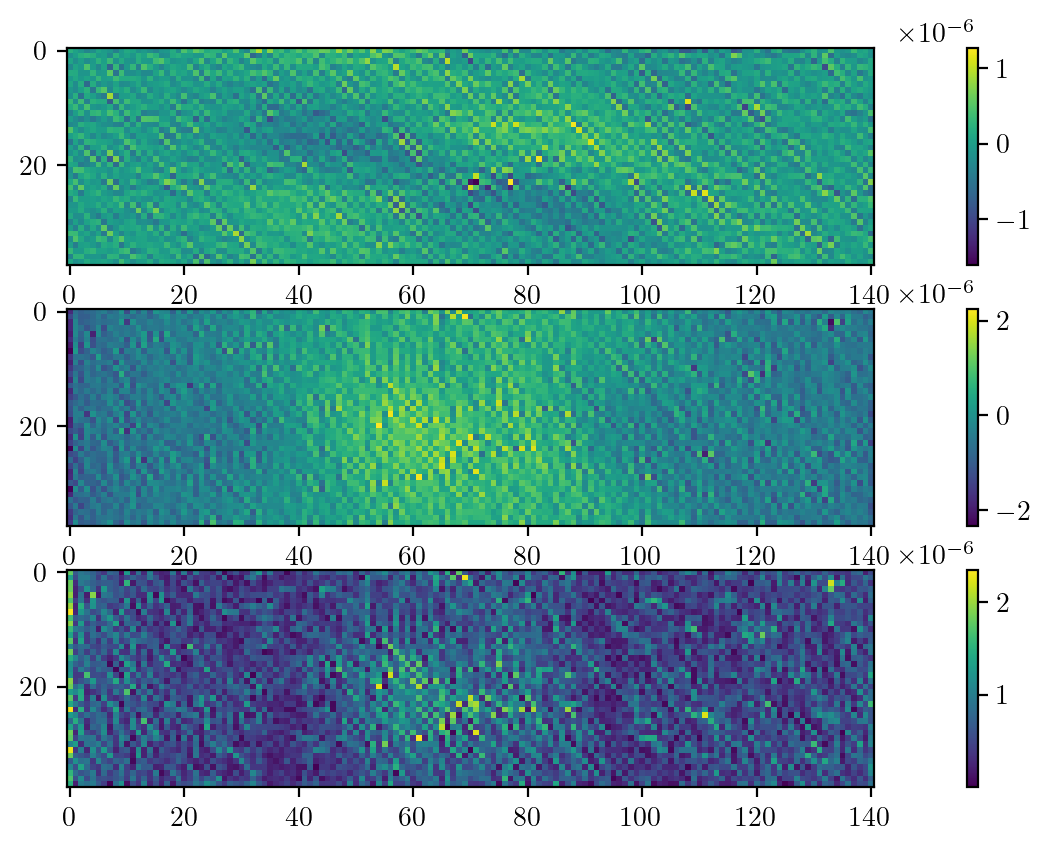

In [134]:
fig = plt.figure()
fig.set_figwidth(12)
plt.subplot(3,1,1)
plt.imshow(np.rot90(JxJy[0,::]))
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(np.rot90(JxJy[1,::]))
plt.colorbar()

plt.subplot(3,1,3)
plt.imshow(np.rot90(np.sqrt(JxJy[0,::]**2 + JxJy[1,::]**2)))
plt.colorbar()

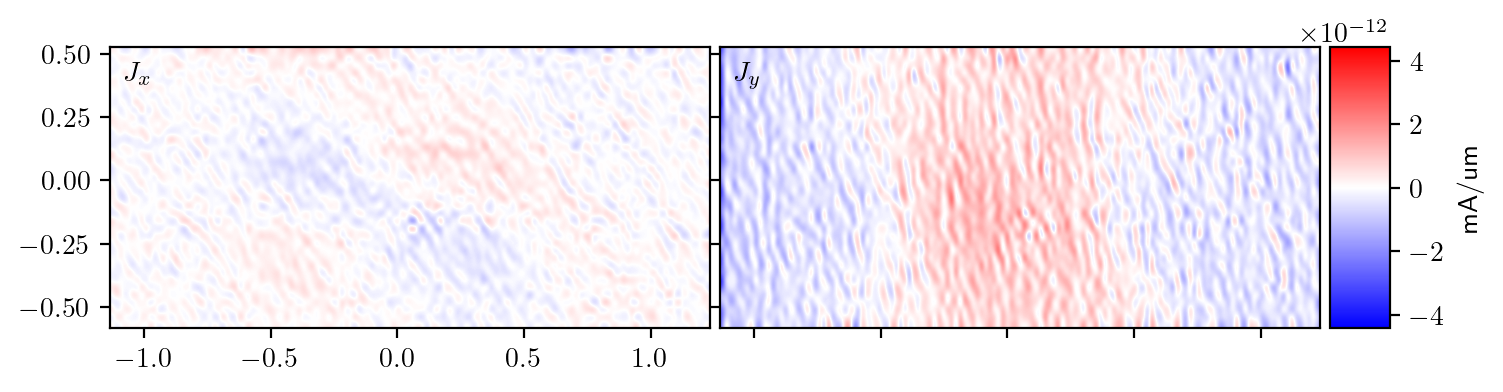

In [117]:
plot_n_components(JxJy * 1e-6, symmetric=True, labels=[r"$J_x$", r"$J_y$"], cmap="bwr", units="mA/um",
imshow_kwargs={
    "extent": [x_vector.min(), x_vector.max(), y_vector.min(), y_vector.max()],
    "interpolation": "bicubic",
    })

## 2. Reconstruction of J by optimization

Here we define a reconstruction scheme by doing an optimization on a tensor of J with two components, so that it produces the expected magnetic field through propagation. 

### 2.3. Define data

dict_keys(['__header__', '__version__', '__globals__', 'BX_map', 'BY_map', 'BZ_map', 'Bnv_map', 'Jx_o_cut', 'Jy_o_cut', 'rx_inv', 'ry_inv'])


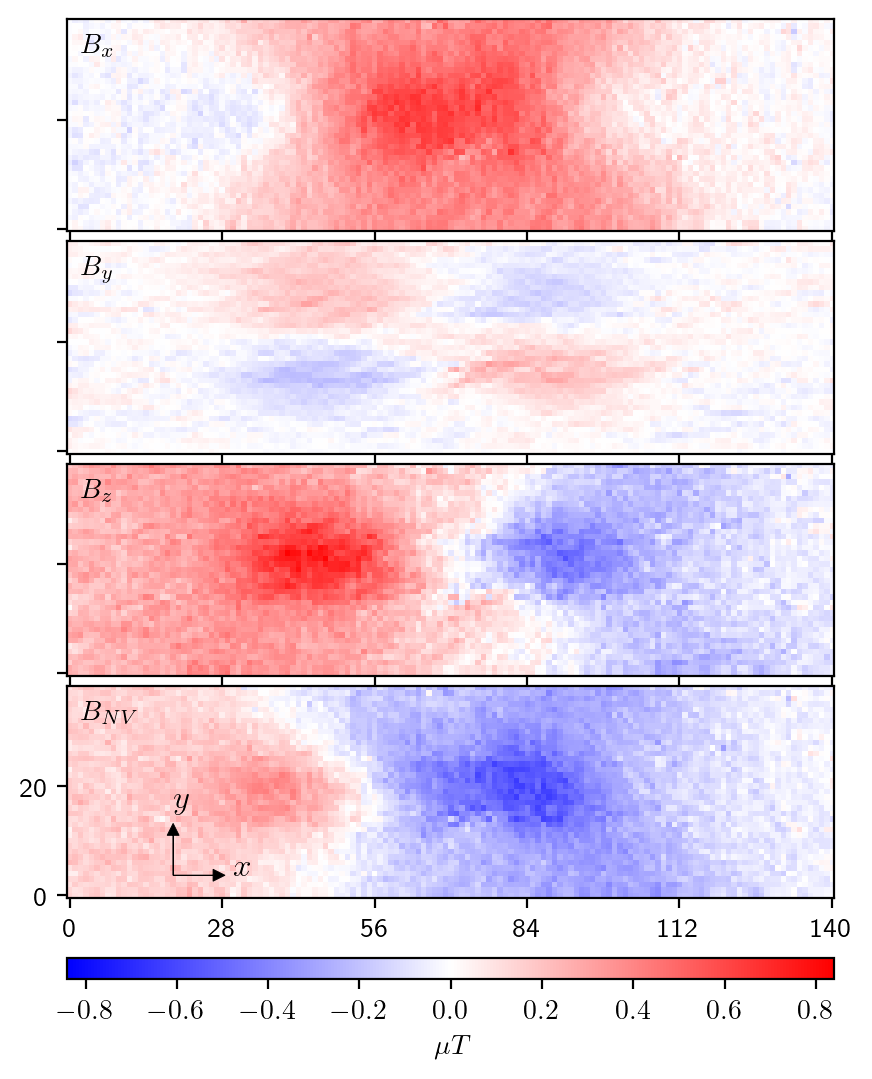

In [26]:
print(mat.keys())

Bx = mat['BX_map'].T
By = mat['BY_map'].T
Bz = mat['BZ_map'].T
Bnv = mat['Bnv_map'].T

B = np.stack((Bx, By, Bz, Bnv), axis=0) * 1e6 # convert to μT

plot_n_components(B, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], cmap="bwr", units=r"$\mu T$", alignment="vertical",)

### 2.2. Define parameters

In [27]:
dx = 0.0169  # μm
dy = 0.0292

height = 0.015          # μm
layer_thickness = 0.030 # μm

theta = 54.7            # degrees
phi = 30.0              # degrees

# Projection object to compute the projection of the vector onto the defined axis
proj = AxisProjectionPropagator(theta=theta, phi=phi)

### 2.3. Define J → B transformation and optimizer loop

In [28]:
W, H = B.shape[-2:]
pad_repl = torch.nn.ReplicationPad2d((H, H, W, W))

# calculate what the next power of two is
expanded_shape = (2, 1024, 512)

# calculate the required padding to get to the expanded shape
pad_width = (expanded_shape[1] - W*3) 
pad_height = (expanded_shape[2] - H*3)

# if the padding is odd, we need to add one more pixel to the right and bottom
if pad_width % 2 == 1:
    pad_left = pad_width // 2 + 1
    pad_right = pad_width // 2
else:
    pad_left = pad_width // 2
    pad_right = pad_width // 2

# similar to height
if pad_height % 2 == 1:
    pad_bottom = pad_height // 2 + 1
    pad_top = pad_height // 2
else:
    pad_bottom = pad_height // 2
    pad_top = pad_height // 2

# calculate the ROI to crop the result to
roi_width = pad_left + W
roi_height = pad_bottom + H

pad_zero = torch.nn.ZeroPad2d((pad_bottom, pad_top, pad_left, pad_right))
propagator = CurrentPropagator2d(source_shape=expanded_shape[-2:],
                                 dx=dx, dy=dy, height=height, layer_thickness=layer_thickness,)

def compute_B_with_repl(J: torch.tensor):
    J = pad_repl(J)
    J = pad_zero(J)
    B = propagator(J)
    B = B[..., roi_width:roi_width+W, roi_height:roi_height+H]
    B_NV = proj.project(B)
    # That's a more general stacking to allow for batch dimension
    B = torch.stack([B[..., -3, :, :], 
                     B[..., -2, :, :], 
                     B[..., -1, :, :], 
                  B_NV[..., :, :]], 
                     dim=-3)
    return B

### 2.4. Define optimization loop

In [29]:

def run_optimization_repl(B, n_iter=1000, plot_interval=100):
    """Run the optimization loop using all three components of B (and B_NV too)
    
    Parameters
    ----------
    B : np.ndarray or torch.tensor
        The measured magnetic field to match with a reconstructed current density

    n_iter : int, optional
        Number of iterations, by default 1000

    plot_interval : int, optional
        Number of iterations between each plot, by default 100
    
    Returns
    -------
    J : torch.tensor
        The reconstructed current density
    """
    # Initialize the current density to optimize for
    J = torch.zeros(size=(2, W, H), requires_grad=True)

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam

    # Add the optimizer to the parameters
    optimizer = optimizer([J], lr=1.)

    # Convert B to a torch tensor of float32
    B = torch.from_numpy(B).float()

    # Make a for loop for training to optimize the current J
    for i in range(n_iter):
        # Compute the predicted B_NV
        B_pred = compute_B_with_repl(J)
        
        # Compute the loss
        loss = loss_fn(B_pred, B)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss
        if i % plot_interval == 0:
            print(f"Loss at iteration {i}: {loss.item()}")
            fig1 = plot_n_components(J.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")
            fig2 = plot_n_components(B_pred.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

            # Display the output in the notebook and clear the output
            display(fig1)
            display(fig2)
            clear_output(wait=True)

            # If the loss is smaller then this value, change the learning rate
            if loss.item() < 1e-8:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-1
            elif loss.item() < 1e-10:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-3
            else:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1.
            
            # If the loss is small enough, stop the optimization
            # if loss.item() < 1e-10:
            #     print('Stopping optimization, converged to a loss of < 1e-10')
            #     break

    return J

Loss at iteration 900: 0.02159346640110016


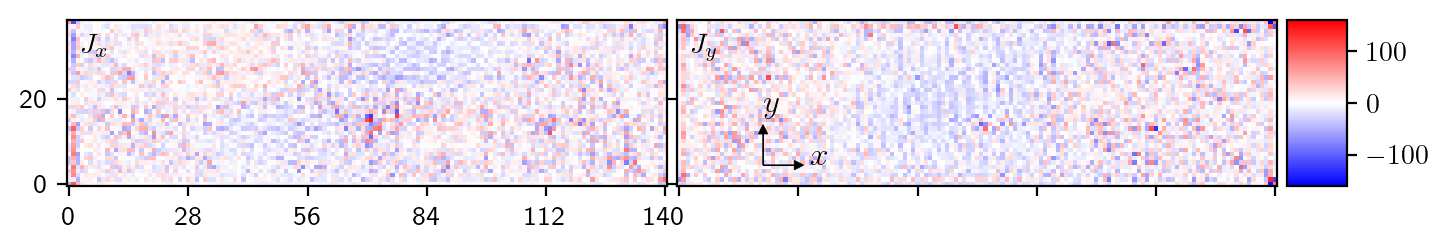

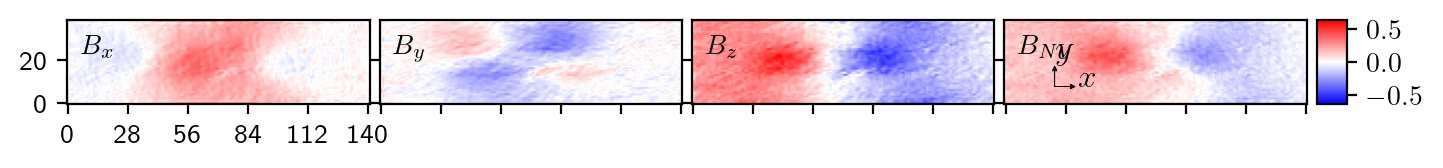

In [31]:
J_pred = run_optimization_repl(B, n_iter=1000, plot_interval=100)

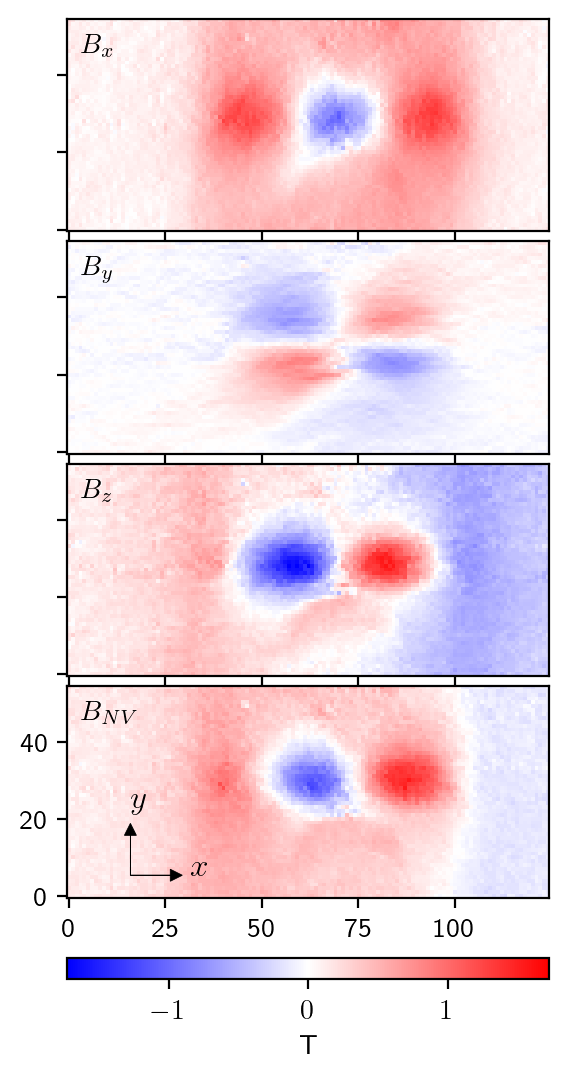

In [32]:
mat = load_matlab_data(__datapath__ / "ExperimentalData" / "Harvard" / "XY_Bnv_Bxyz_Jxy_SChenJJ_data2.mat")

Bx = mat['BX_map'].T
By = mat['BY_map'].T
Bz = mat['BZ_map'].T
Bnv = mat['Bnv_map'].T

B = np.stack((Bx, By, Bz, Bnv), axis=0) * 1e6  # Convert to μT

plot_n_components(B, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], cmap="bwr", units="T", alignment="vertical",)

In [64]:
dx = 0.0204  # μm
dy = 0.0291

height = 0.015          # μm
layer_thickness = 0.030 # μm

theta = -54.7            # degrees
phi = -150              # degrees

# Projection object to compute the projection of the vector onto the defined axis
proj = AxisProjectionPropagator(theta=theta, phi=phi)

W, H = B.shape[-2:]
pad_repl = torch.nn.ReplicationPad2d((H, H, W, W))

# calculate what the next power of two is
expanded_shape = (2, 1024, 512)

# calculate the required padding to get to the expanded shape
pad_width = (expanded_shape[1] - W*3) 
pad_height = (expanded_shape[2] - H*3)

# if the padding is odd, we need to add one more pixel to the right and bottom
if pad_width % 2 == 1:
    pad_left = pad_width // 2 + 1
    pad_right = pad_width // 2
else:
    pad_left = pad_width // 2
    pad_right = pad_width // 2

# similar to height
if pad_height % 2 == 1:
    pad_bottom = pad_height // 2 + 1
    pad_top = pad_height // 2
else:
    pad_bottom = pad_height // 2
    pad_top = pad_height // 2

# calculate the ROI to crop the result to
roi_width = pad_left + W
roi_height = pad_bottom + H

pad_zero = torch.nn.ZeroPad2d((pad_bottom, pad_top, pad_left, pad_right))
propagator = CurrentPropagator2d(source_shape=expanded_shape[-2:],
                                 dx=dx, dy=dy, height=height, layer_thickness=layer_thickness,)

def compute_B_with_repl(J: torch.tensor):
    J = pad_repl(J)
    J = pad_zero(J)
    B = propagator(J)
    B = B[..., roi_width:roi_width+W, roi_height:roi_height+H]
    B_NV = proj.project(B)
    # That's a more general stacking to allow for batch dimension
    B = torch.stack([B[..., -3, :, :], 
                     B[..., -2, :, :], 
                     B[..., -1, :, :], 
                  B_NV[..., :, :]], 
                     dim=-3)
    return B

def run_optimization_repl(B, n_iter=1000, plot_interval=100):
    """Run the optimization loop using all three components of B (and B_NV too)
    
    Parameters
    ----------
    B : np.ndarray or torch.tensor
        The measured magnetic field to match with a reconstructed current density

    n_iter : int, optional
        Number of iterations, by default 1000

    plot_interval : int, optional
        Number of iterations between each plot, by default 100
    
    Returns
    -------
    J : torch.tensor
        The reconstructed current density
    """
    # Initialize the current density to optimize for
    J = torch.zeros(size=(2, W, H), requires_grad=True)

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam

    # Add the optimizer to the parameters
    optimizer = optimizer([J], lr=1.)

    # Convert B to a torch tensor of float32
    B = torch.from_numpy(B).float()

    # Make a for loop for training to optimize the current J
    for i in range(n_iter):
        # Compute the predicted B_NV
        B_pred = compute_B_with_repl(J)
        
        # Compute the loss
        loss = loss_fn(B_pred, B)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss
        if i % plot_interval == 0:
            print(f"Loss at iteration {i}: {loss.item()}")
            fig1 = plot_n_components(J.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")
            fig2 = plot_n_components(B_pred.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

            # Display the output in the notebook and clear the output
            display(fig1)
            display(fig2)
            clear_output(wait=True)

            # If the loss is smaller then this value, change the learning rate
            if loss.item() < 1e-8:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-1
            elif loss.item() < 1e-10:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-3
            else:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1.
            
            # If the loss is small enough, stop the optimization
            # if loss.item() < 1e-10:
            #     print('Stopping optimization, converged to a loss of < 1e-10')
            #     break

    return J

Loss at iteration 3900: 3.1542211218038574e-05


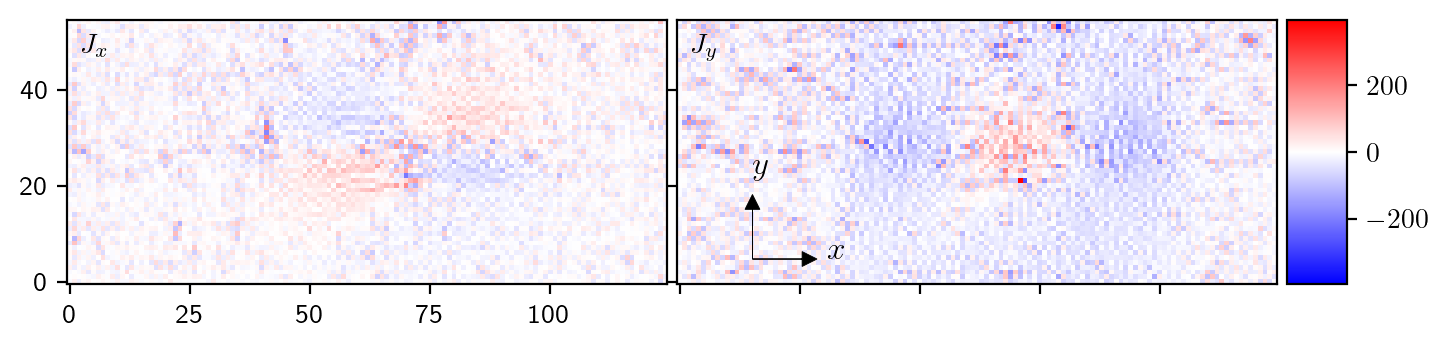

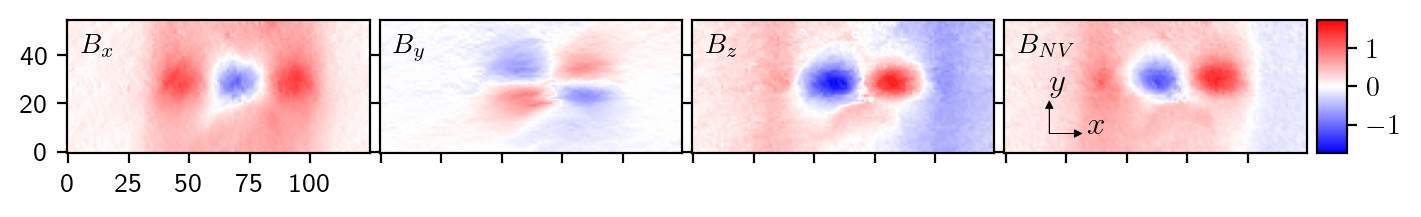

In [36]:
J_pred = run_optimization_repl(B, n_iter=1000, plot_interval=100)

## 3. Reconstruction of J with a conv net

In [65]:
from magrec.nn.utils import create_zero_padder

# Here we define the loss function and the optimization algorithm
def train_net(B, net: torch.nn.Module = None, n_iter=1000, plot_interval=100, lr=1.):
    """Run the optimization loop.
    
    Parameters
    ----------
    B : np.ndarray or torch.tensor
        The measured magnetic field to match with a reconstructed current density

    n_iter : int, optional
        Number of iterations, by default 1000

    plot_interval : int, optional
        Number of iterations between each plot, by default 100
    
    Returns
    -------
    J : torch.tensor
        The reconstructed current density
    """ 
    # Define the loss function and the optimizer
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam
    if net is None:
        net = GeneratorCNN(n_channels_in=4, n_channels_out=2)

    # Add the optimizer to the parameters
    optimizer = optimizer(net.parameters(), lr=lr)

    # Convert B to a torch tensor of float32
    if isinstance(B, np.ndarray):
        B = torch.from_numpy(B).float()
    else:
        B = B.float()

    # Pad B with replication to the closest multiple of 16
    minimal_size = np.ceil(np.array(B.shape[-2:]) / 16) * 16
    pad_size = minimal_size - np.array(B.shape[-2:])
    B = torch.nn.functional.pad(B, pad=(0, int(pad_size[1]), 0, int(pad_size[0])), mode='replicate')

    # Extract the B_NV component from the measured B
    B_NV = B[3, ...]

    # Add a batch dimension, since we are optimizing only on one sample
    B = B[None, ...]
    B_NV = B_NV[None, None, ...]

    W, H = B.shape[-2:]

    
    pad_repl = torch.nn.ReplicationPad2d((H, H, W, W))

    # calculate what the next power of two is
    expanded_shape = (2, 512, 512)
    

    pad_zero, (roi_left, roi_bottom) = create_zero_padder(expanded_shape[-2:], W, H)

    propagator = CurrentPropagator2d(source_shape=expanded_shape[-2:],
                                    dx=dx, dy=dy, height=height, layer_thickness=layer_thickness,)

    def compute_B_with_repl(J: torch.tensor):
        J = pad_repl(J)
        J = pad_zero(J)
        B = propagator(J)
        B_NV = proj.project(B)
        # That's a more general stacking to allow for batch dimension
        B = torch.stack([B[..., -3, :, :], 
                        B[..., -2, :, :], 
                        B[..., -1, :, :], 
                    B_NV[..., :, :]], 
                        dim=-3)
        return B[..., roi_left:roi_left+W, roi_bottom:roi_bottom+H]


    # Initialize a list to track loss and update it on each iteration
    track_loss = []

    # Prepare a figure to plot the loss
    fig_loss = plt.figure('Loss')
    fig_loss.suptitle('Loss as a function of iteration')
    fig_loss.supxlabel('Iteration')
    fig_loss.supylabel('Loss')
    
    # Make an axis to plot the loss
    ax_loss = fig_loss.add_subplot(111)

    def show_progress(B_pred, J_rec):
        print(f"Loss at iteration {i}: {loss.item()}")
        fig1 = plot_n_components(J_rec.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")
        fig2 = plot_n_components(B_pred.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

        # Plot the loss as a function of iteration
        ax_loss.clear()
        ax_loss.plot(track_loss)
        
        # Make y axis log scale
        ax_loss.set_yscale('log')

        # Display the output in the notebook and clear the output
        display(fig1)
        display(fig2)
        display(fig_loss)
        clear_output(wait=True)


    def print_changed_lr(lr):
        """Print once if the learning rate changed"""
        if print_changed_lr.current_lr != lr:
            print(f"Learning rate changed to {lr}")
        print_changed_lr.current_lr = lr

    print_changed_lr.current_lr = 1

    # Make a for loop for training to optimize the current J
    for i in range(n_iter):
        # Compute the predicted B_NV
        J_pred = net(B)

        # Compute the predicted B that corresponds to the output current
        B_pred = compute_B_with_repl(J_pred)

        # Extract the B_NV component
        B_pred_NV = B_pred[:, 3, ...]

        # Add a dimension that corresponds to the component
        B_pred_NV = B_pred_NV[:, None, ...]
        
        # Compute the loss
        loss = loss_fn(B, B_pred)
        # Add the loss to the list
        track_loss.append(loss.item())
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss
        if i % plot_interval == 0:
            show_progress(B_pred, J_pred)

    return net

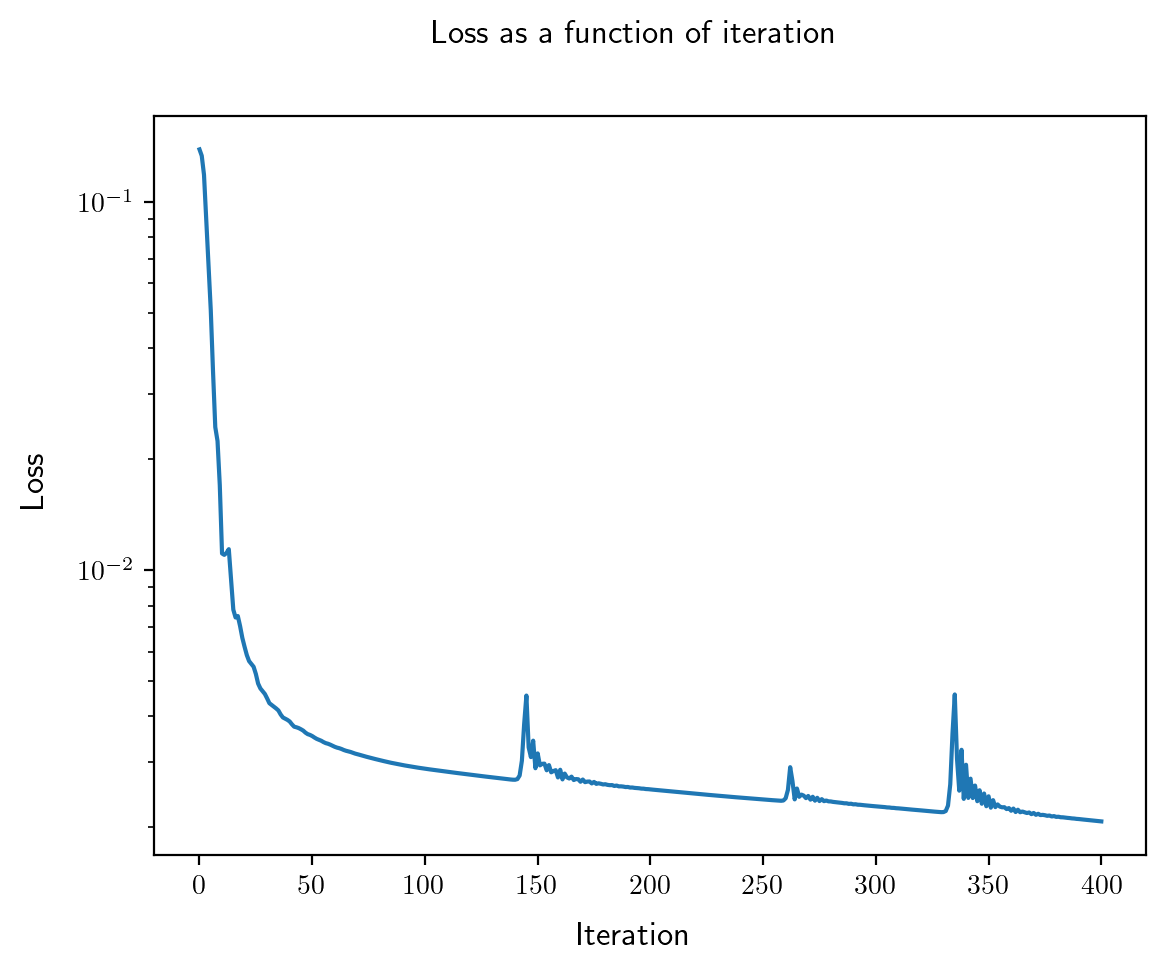

In [41]:
net = train_net(B, n_iter=500, plot_interval=100, lr=0.01)

In [62]:
def test_net(net: torch.nn.Module, B: torch.Tensor):
    net.eval()

    # Convert B to a torch tensor of float32
    if isinstance(B, np.ndarray):
        B = torch.from_numpy(B).float()
    else: 
        B = B.float()

    B = B[None, ...]
    B_NV = B[:, 3, ...]

    J_pred = net(B)
    B_pred = compute_B_with_repl(J_pred)

    fig1 = plot_n_components(J_pred.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")
    fig2 = plot_n_components(B_pred.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

    display(fig1, fig2)
    pass

In [63]:
test_net(net, B)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 7 but got size 8 for tensor number 1 in the list.

### 3.2. Conv net that reconstucts only from one component

In [51]:
# Here we define the loss function and the optimization algorithm
def train_net(B, net: torch.nn.Module = None, n_iter=1000, plot_interval=100, lr=1.):
    """Run the optimization loop.
    
    Parameters
    ----------
    B : np.ndarray or torch.tensor
        The measured magnetic field to match with a reconstructed current density

    n_iter : int, optional
        Number of iterations, by default 1000

    plot_interval : int, optional
        Number of iterations between each plot, by default 100
    
    Returns
    -------
    J : torch.tensor
        The reconstructed current density
    """ 
    # Define the loss function and the optimizer
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam
    if net is None:
        net = GeneratorCNN(n_channels_in=1, n_channels_out=2)

    # Add the optimizer to the parameters
    optimizer = optimizer(net.parameters(), lr=lr)

    # Convert B to a torch tensor of float32
    if isinstance(B, np.ndarray):
        B = torch.from_numpy(B).float()
    else:
        B = B.float()

    # Pad B with replication to the closest multiple of 16
    minimal_size = np.ceil(np.array(B.shape[-2:]) / 16) * 16
    pad_size = minimal_size - np.array(B.shape[-2:])
    B = torch.nn.functional.pad(B, pad=(0, int(pad_size[1]), 0, int(pad_size[0])), mode='replicate')

    # Show how the training data looks like
    plot_n_components(B.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

    # Extract the B_NV component from the measured B
    B_NV = B[3, ...]

    # Add a batch dimension, since we are optimizing only on one sample
    B = B[None, ...]
    B_NV = B_NV[None, None, ...]

    W, H = B.shape[-2:]

    
    pad_repl = torch.nn.ReplicationPad2d((H, H, W, W))

    # calculate what the next power of two is
    expanded_shape = (2, 512, 512)

    # 384, 192
    

    pad_zero, (roi_left, roi_bottom) = create_zero_padder(expanded_shape[-2:], W, H)

    propagator = CurrentPropagator2d(source_shape=expanded_shape[-2:],
                                    dx=dx, dy=dy, height=height, layer_thickness=layer_thickness,)

    def compute_B_with_repl(J: torch.tensor):
        J = pad_repl(J)
        J = pad_zero(J)
        B = propagator(J)
        B_NV = proj.project(B)
        # That's a more general stacking to allow for batch dimension
        B = torch.stack([
            B[..., -3, :, :], 
            B[..., -2, :, :], 
            B[..., -1, :, :], 
            B_NV[..., :, :]
            ], dim=-3,)
        B_roi = B[..., roi_left:roi_left+W, roi_bottom:roi_bottom+H]
        return B_roi 


    # Initialize a list to track loss and update it on each iteration
    track_loss = []

    # Prepare a figure to plot the loss
    fig_loss = plt.figure('Loss')
    fig_loss.suptitle('Loss as a function of iteration')
    fig_loss.supxlabel('Iteration')
    fig_loss.supylabel('Loss')
    
    # Make an axis to plot the loss
    ax_loss = fig_loss.add_subplot(111)

    def show_progress(B_pred, J_rec):
        print(f"Loss at iteration {i}: {loss.item()}")
        fig1 = plot_n_components(J_rec.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")
        fig2 = plot_n_components(B_pred.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

        # Plot the loss as a function of iteration
        ax_loss.clear()
        ax_loss.plot(track_loss)
        
        # Make y axis log scale
        ax_loss.set_yscale('log')

        # Display the output in the notebook and clear the output
        display(fig1)
        display(fig2)
        display(fig_loss)
        clear_output(wait=True)


    def print_changed_lr(lr):
        """Print once if the learning rate changed"""
        if print_changed_lr.current_lr != lr:
            print(f"Learning rate changed to {lr}")
        print_changed_lr.current_lr = lr

    print_changed_lr.current_lr = 1

    # Make a for loop for training to optimize the current J
    for i in range(n_iter):
        # Compute the predicted B_NV
        J_pred = net(B_NV)

        # Compute the predicted B that corresponds to the output current
        B_pred = compute_B_with_repl(J_pred)

        # Extract the B_NV component
        B_pred_NV = B_pred[:, 3, ...]

        # Add a dimension that corresponds to the component
        B_pred_NV = B_pred_NV[:, None, ...]
        
        # Compute the loss
        loss = loss_fn(B_NV, B_pred_NV)
        # Add the loss to the list
        track_loss.append(loss.item())
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss
        if i % plot_interval == 0:
            show_progress(B_pred, J_pred)

        
        # If the loss is small enough, stop the optimization
        if loss.item() < 1e-6:
            print('Stopping optimization, converged to a loss of < 1e-10')
            show_progress(B_pred, J_pred)
            break

    return net

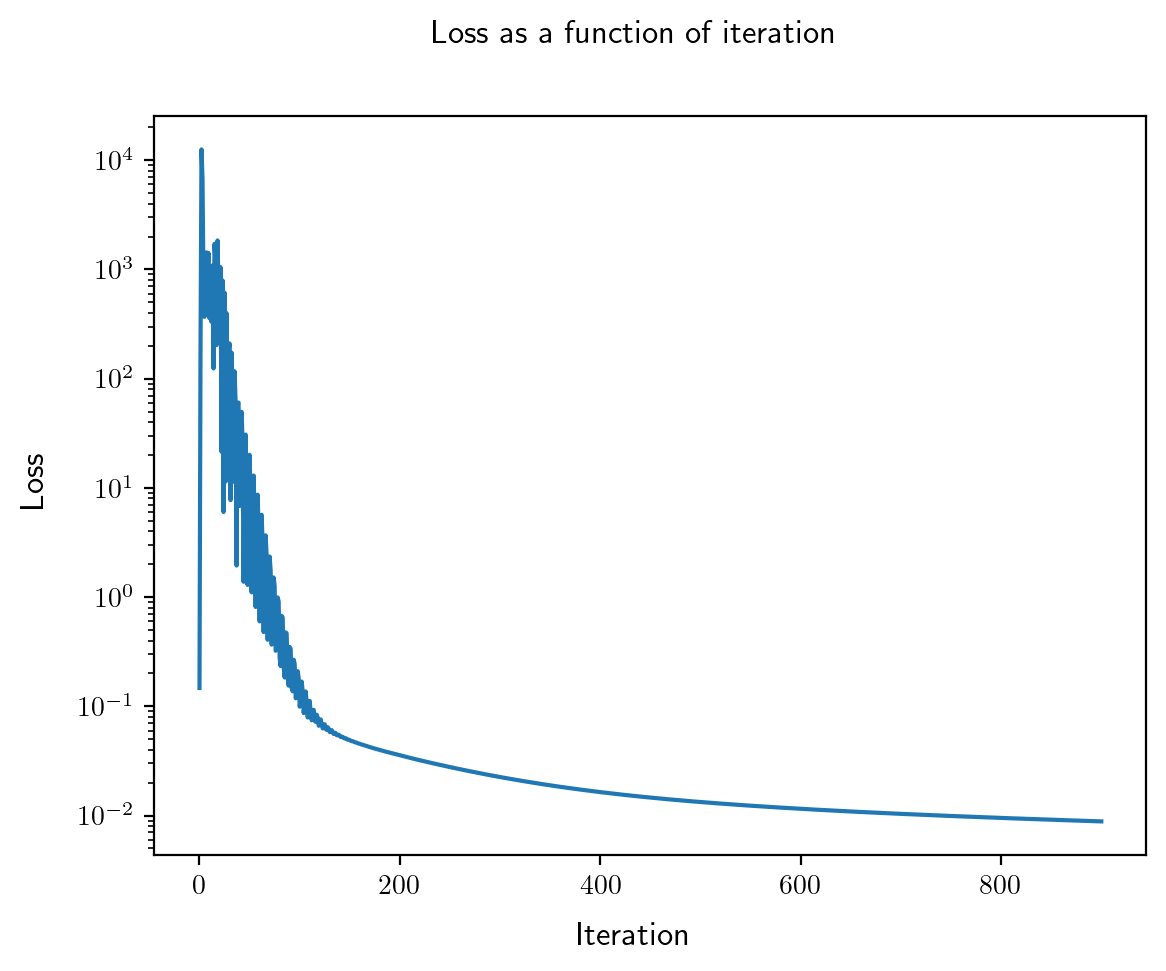

In [56]:
net_1 = train_net(B, n_iter=1000, plot_interval=100)

In [60]:
B.shape

(4, 125, 55)